In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from scipy import interpolate

In [2]:
# Set plt settings for a better looking plot
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 16
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 10
plt.rcParams["lines.markeredgewidth"] = 2
# plt.rcParams["lines.markerfacecolor"] = "none"
# plt.rcParams["lines.markeredgecolor"] = "black"

In [3]:
def get_data(entity, project, jobs=None):
    api = wandb.Api()
    runs = api.runs(entity + "/" + project)
    if jobs is not None:
        runs = [r for r in runs if "job" in r.config and int(r.config["job"]) in jobs]

    data = {}
    for r in runs:
        g = r.config["problem"]
        a = r.config["algo"]
        if g not in data:
            data[g] = {}
        if a not in data[g]:
            data[g][a] = []
        data[g][a].append(r)
    return data

In [4]:
class GroupedRun:
    def __init__(self, algo, runs):
        self.algo = algo
        self.runs = runs
        self.interpolators = {}
        self.ranges = {}

    # length
    def __len__(self):
        return len(self.runs)

    def interpolate(self, y):
        if y not in self.interpolators:
            self.interpolators[y] = []
            self.ranges[y] = (- np.inf, np.inf)
        for r in self.runs:
            h = r.history()
            i = interpolate.interp1d(h["evaluations"], h[y])
            self.interpolators[y].append(i)
            self.ranges[y] = (max(self.ranges[y][0], h["evaluations"].min()), min(self.ranges[y][1], h["evaluations"].max()))

    def compute(self, field, x):
        # filter x for range
        x = [x[i] for i in range(len(x)) if self.ranges[field][0] <= x[i] <= self.ranges[field][1]]
        y = []
        for i in self.interpolators[field]:
            y.append(i(x))
        return np.array(x), np.array(y)

    def get_mean_std(self, field, x):
        x, y = self.compute(field, x)
        return np.mean(y, axis=0), np.std(y, axis=0)

    def has_field(self, field):
        # check if runs have field
        for r in self.runs:
            if field not in r.history():
                return False
        return True

In [5]:
entity = "sureli"
project = "ucea"
# jobs = None
jobs = [766713, 766237, 766726, 766718, 766710, 766716, 76627]

colors = {
    "LUCIE":"blue",
    "EA":"red",
    "MultiEA":"green",
}
markers =  {
    "LUCIE":"^",
    "EA":"o",
    "MultiEA":"s",
}

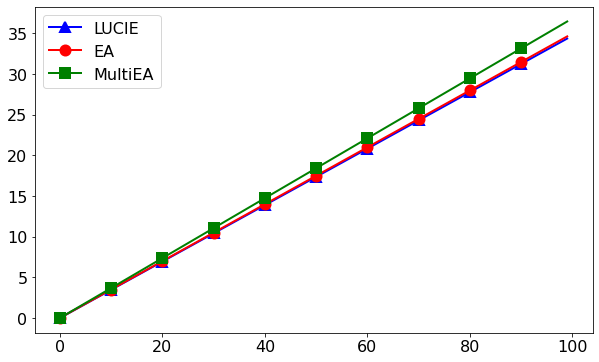

In [7]:
for a in colors.keys():
    x = range(100)
    y = np.array(x) * np.random.random()
    plt.plot(x, y, color=colors[a], label=a, marker=markers[a], markevery=10)
plt.legend()

In [8]:
games = get_data(entity, project, jobs)

In [14]:
len(mean)

7200

chaser UCEA fitness 12


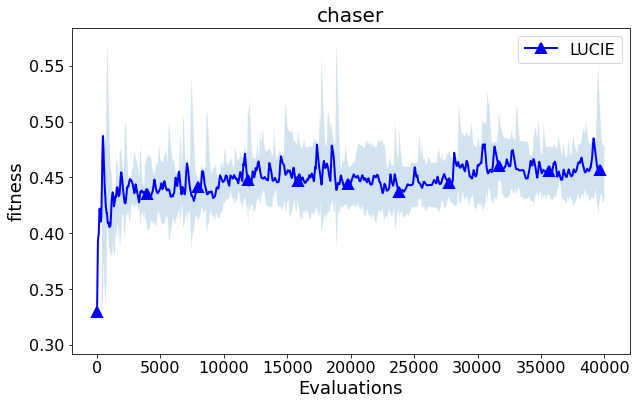

chaser UCEA validation fitness 12


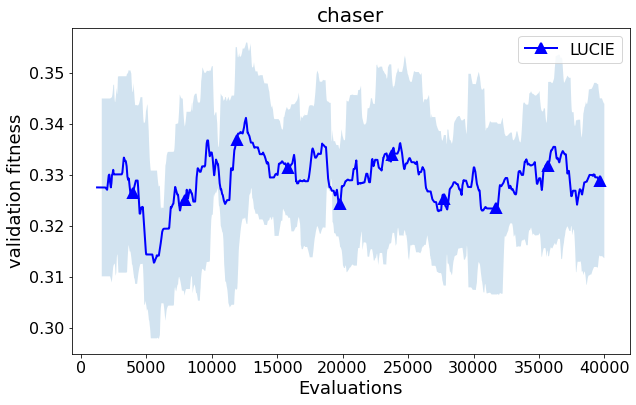

leaper UCEA fitness 24


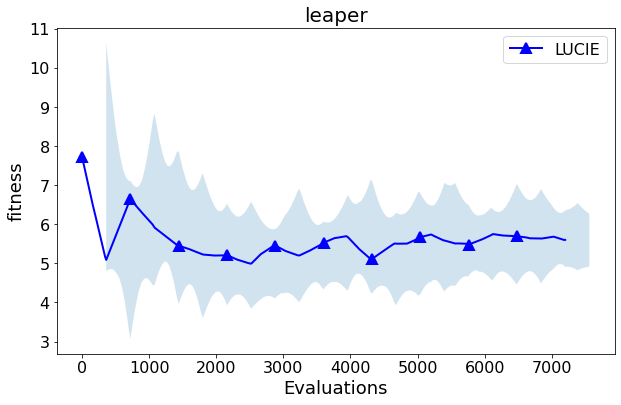

leaper UCEA validation fitness 24


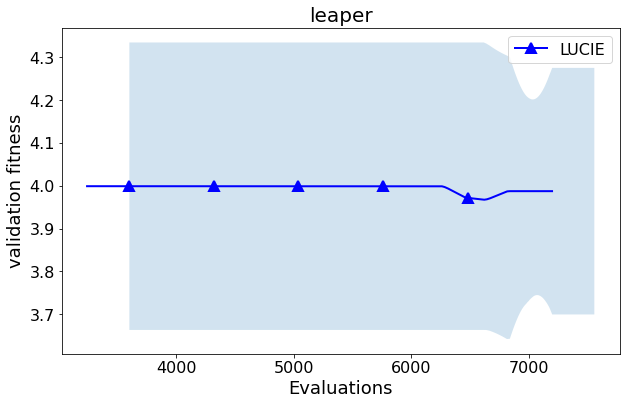

starpilot UCEA fitness 24


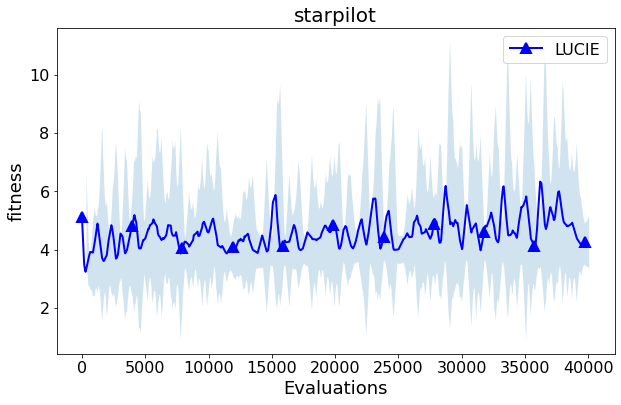

starpilot UCEA validation fitness 24


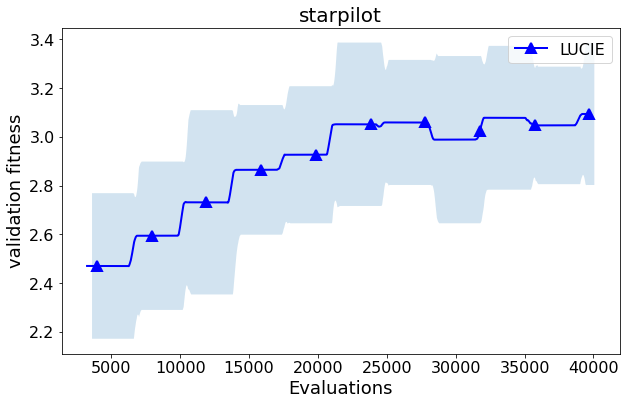

leading_ones UCEA fitness 9
leading_ones MultiEA fitness 9
leading_ones EA fitness 9


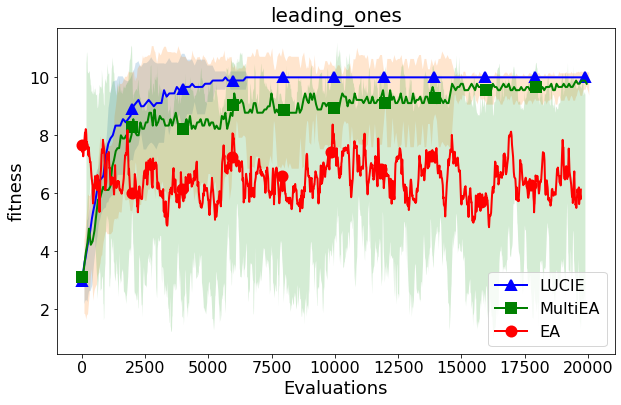

leading_ones UCEA validation fitness 9
leading_ones MultiEA validation fitness 9
leading_ones EA validation fitness 9


No handles with labels found to put in legend.


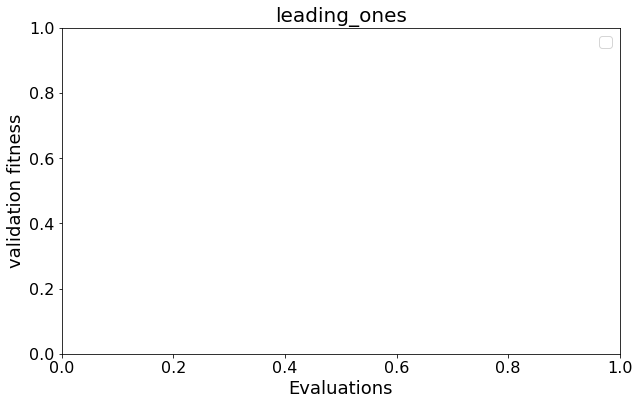

In [16]:
for g, runs in games.items():
    for y in ["fitness", "validation fitness"]:
        for a, r in runs.items():
            group = GroupedRun(a, r)
            print(f"{g} {a} {y} {len(group)}")
            if not group.has_field(y):
                continue
            group.interpolate(y)
            mean, std = group.get_mean_std(y, np.arange(group.ranges[y][0], group.ranges[y][1]))
            # Use LUCIE instead of UCEA as label
            if a == "UCEA":
                a = "LUCIE"
            plt.plot(
                mean, 
                label=a,
                color=colors[a],
                marker=markers[a],
                markevery=len(mean) // 10,
                )
            plt.fill_between(np.arange(group.ranges[y][0], group.ranges[y][1]), mean - std, mean + std, alpha=0.2)
        plt.xlabel("Evaluations")
        plt.ylabel(y)
        plt.legend()
        plt.title(f"{g}")
        # save figure
        plt.savefig(f"paper_figures/{g}_{y}.png")
        plt.show()